# Neural-Network-With-Tensorflow

Tensorflow is a deeplearning framework used to train deeplearning models easily which is opensource and maintained by google. 

This notebook deals with training an end to end neural network. We can train a neural network just by using the `numpy` library but that's a long and tedious process so for to make this easier we will use tensorflow with the latest version.

For this notebook we will build a simple hand sign classifier with the help of a 3 layered neural network.

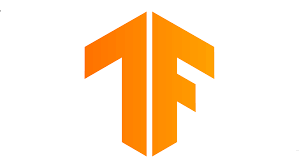

In [1]:
# Check for tensorflow version
import tensorflow as tf
tf.__version__

'2.5.0'

In [21]:
# importing libraries we will need
import h5py
import numpy as np
import time
import matplotlib.pyplot as plt


## Getting our data ready 

For this notebook our dataset is present in a `h5py` file, let's get it ready so that we can use it.

In [3]:
train_dataset = h5py.File('/content/drive/MyDrive/dataset/train_signs.h5', "r")
test_dataset = h5py.File('/content/drive/MyDrive/dataset/test_signs.h5', "r")

Here we will call the TensorFlow dataset created on a HDF5 file, which we can use in place of a Numpy array to store our datasets.

In [4]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [5]:
# Check for the type
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

TensorFlow Datasets are generators, we can't access directly the contents unless we iterate over them in a for loop. Let's do this by using a `iter` and `next` in python.

In [6]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [7]:
# check for details in y_train
print(y_train.element_spec)

TensorSpec(shape=(), dtype=tf.int64, name=None)


## Normalizing function

Now, let's create a function which normalizes our images like converts them into tensors and in the dimension (64 x 64 x 3, 1).

To apply this function to each element we will use `map()` function.

In [8]:
def normalize(image):

    image = tf.cast(image, tf.float32) / 256.0
    image = tf.reshape(image, [-1,1])
    return image

In [9]:
# applying the function to each image 
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [10]:
new_train.element_spec

TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None)

In [11]:
x_train.element_spec

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)

In [12]:
print(next(iter(new_train)))

tf.Tensor(
[[0.88671875]
 [0.859375  ]
 [0.8359375 ]
 ...
 [0.8125    ]
 [0.81640625]
 [0.81640625]], shape=(12288, 1), dtype=float32)


## One Hot Encodings

In deeplearning sometimes we come accross some of the problems where the y mappings are not just classified between two(0, 1) but different. And hence to convert this into (0, 1) we use one_hot_encoding.

![image](https://i.ibb.co/kQ9bYdK/onehot.png)

This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1)


In [13]:
def one_hot_matrix(label, depth=6):
    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0), (depth,1))
    
    return one_hot

In [14]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [15]:
print(next(iter(new_y_test)))

tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(6, 1), dtype=float32)


## Initializing the parameters

Now we'll initialize a vector of numbers between zero and one.

The function we are using is - `tf.keras.initializers.GlorotNormal(seed=1)` - we are using a `seed` here so that the initializer always comes up with the same random values.

This function draws samples from a truncated normal distribution centered on 0, with `stddev = sqrt(2 / (fan_in + fan_out))`, where `fan_in` is the number of input units and `fan_out` is the number of output units, both in the weight tensor.

Initializing parameters to build a neural network with TensorFlow. The shapes are: <br>
                        W1 : [25, 12288]<br>
                        b1 : [25, 1]<br>
                        W2 : [12, 25]<br>
                        b2 : [12, 1]<br>
                        W3 : [6, 12]<br>
                        b3 : [6, 1]

In [16]:
def initialize_parameters():
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   

    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6, 12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

## Two most important steps :

>1. Implement forward propagation <br>
>2. Retrieve the gradients and train the model

We are training our model with tensorflow and while using it we have this benefit of not using the backpropagation as tensorflow takes care of it for us. This is also the reason why tensorflow is a great deeplearning framework.

We need to only work on forward propagation.

Here, we'll use a TensorFlow decorator, `@tf.function`, which builds a computational graph to execute the function. `@tf.function` is polymorphic, which comes in very handy, as it can support arguments with different data types or shapes, and be used with other languages, such as Python. This means that you can use data dependent control flow statements.

When you use `@tf.function` to implement forward propagation, the computational graph is activated, which keeps track of the operations. This is so you can calculate your gradients with backpropagation.

Implementing the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR


In [17]:
@tf.function
def forward_propagation(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)
    
    return Z3

## Computing the cost

Here again, `@tf.function` decorator steps in and saves us time. All we need to do is specify how to compute the cost, and we can do so in one simple step by using:

`tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = ..., y_pred = ..., from_logits=True))`

In [18]:
@tf.function
def compute_cost(logits, labels):

    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = labels, y_pred = logits, from_logits=True))
    
    return cost

## Training the model

Almost all of our functions are ready to use in the model except the deciding the optimizer which we will decide in the `model()` function. 
For this case we are using `SGD` - stochastic gradient descent.

The `tape.gradient` function: this allows us to retrieve the operations recorded for automatic differentiation inside the GradientTape block. Then, calling the optimizer method `apply_gradients`, will apply the optimizer's update rules to each trainable parameter.

`tf.Data.dataset = dataset.prefetch(8)` - What this does is prevent a memory bottleneck that can occur when reading from disk. `prefetch()` sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory.

In [19]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    costs = []                                        # To keep track of the cost
    
    # Initializing our parameters
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Optimizer selection
    optimizer = tf.keras.optimizers.SGD(learning_rate)

    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            # Select a minibatch
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(minibatch_X, parameters)
                # 2. loss
                minibatch_cost = compute_cost(Z3, minibatch_Y)
                
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost / minibatch_size

        # Print the cost every epoch
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save the parameters in a variable
    print ("Parameters have been trained!")

    return parameters

Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
Cost after epoch 50: 0.570628
Cost after epoch 60: 0.560898
Cost after epoch 70: 0.550808
Cost after epoch 80: 0.540497
Cost after epoch 90: 0.488141
Cost after epoch 100: 0.478272
Cost after epoch 110: 0.472865
Cost after epoch 120: 0.468991
Cost after epoch 130: 0.466015
Cost after epoch 140: 0.463661
Cost after epoch 150: 0.461677
Cost after epoch 160: 0.459951
Cost after epoch 170: 0.458392
Cost after epoch 180: 0.456970
Cost after epoch 190: 0.455647


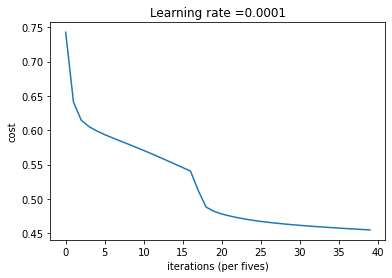

Parameters have been trained!


{'W1': <tf.Variable 'Variable:0' shape=(25, 12288) dtype=float32, numpy=
 array([[ 0.00159522, -0.00737918,  0.00893291, ..., -0.01227797,
          0.01642201,  0.00506484],
        [ 0.02264025,  0.0067227 ,  0.00795862, ...,  0.00284724,
          0.01910819,  0.00122853],
        [-0.00173583, -0.00872451, -0.01410439, ..., -0.00733834,
          0.02050859, -0.0268302 ],
        ...,
        [-0.00126929,  0.01729332,  0.02082342, ...,  0.01709594,
          0.00429358, -0.00733263],
        [ 0.00268257,  0.00410495,  0.00936706, ...,  0.01222281,
         -0.02717606,  0.01498352],
        [-0.00145541,  0.02459595,  0.00339064, ..., -0.02478788,
          0.02716016, -0.00306428]], dtype=float32)>,
 'W2': <tf.Variable 'Variable:0' shape=(12, 25) dtype=float32, numpy=
 array([[ 0.03270398, -0.13031   ,  0.16566683, -0.20850259, -0.2404858 ,
         -0.10598166, -0.01016674,  0.12317106, -0.00411659, -0.3709333 ,
          0.45312327, -0.3642326 ,  0.09766971,  0.18042909, -0.05

In [22]:
# training the model on the data set 
model(new_train, new_y_train, new_test, new_y_test, num_epochs=200)

So, we are done with our building a 3 layered neural network with tensorflow.